# Review Data from TransparentCalifornia

In [33]:
import sys
!{sys.executable} -m pip install pandas matplotlib ipywidgets scipy pandas_profiling > /dev/null
!{sys.executable} -m pip install genderize gender_guesser seaborn statsmodels datadotworld[pandas] sqlite3 > /dev/null

import requests
from io import StringIO
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib
%matplotlib inline
from genderize import Genderize
import gender_guesser.detector as gender
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import datadotworld as dw
import sqlite3



You should consider upgrading via the 'pip install --upgrade pip' command.
  ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read in TransparentCalifornia data
df = None
for year in range(2011,2020):    
    year_df = pd.read_csv(f'TransparentCalifornia/state-of-california-{year}.csv.zip', compression='zip')
    for col in ['Base Pay', 'Benefits', 'Other Pay', 'Total Pay', 'Overtime Pay', 'Total Pay & Benefits']:
        year_df[col] = pd.to_numeric(year_df[col], errors='coerce').astype('float64').round(2)
    year_df['Job Title'] = year_df['Job Title'].str.title().str.strip()
    year_df['Employee Name'] = year_df['Employee Name'].str.title()
    print(f'Year {year} Rows {len(year_df)}')
    df = year_df if df is None else df.append(year_df)

Year 2011 Rows 246599
Year 2012 Rows 244881
Year 2013 Rows 235071
Year 2014 Rows 240531
Year 2015 Rows 246273


/Users/bryanchan/.pyenv/versions/3.7.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Year 2016 Rows 248279
Year 2017 Rows 247697
Year 2018 Rows 253503
Year 2019 Rows 260277


In [3]:
print(df.dtypes)

Employee Name            object
Job Title                object
Base Pay                float64
Overtime Pay            float64
Other Pay               float64
Benefits                float64
Total Pay               float64
Total Pay & Benefits    float64
Year                      int64
Notes                    object
Agency                   object
Status                   object
dtype: object


### Profiling Report (Disabled)

In [4]:
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
# profile

<AxesSubplot:>

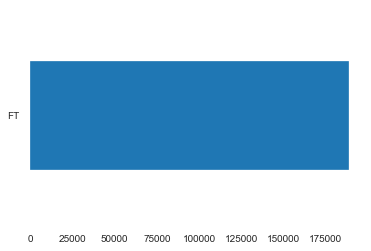

In [5]:
df['Status'].value_counts().plot(kind='barh')

### Top 20 Job Titles

<AxesSubplot:>

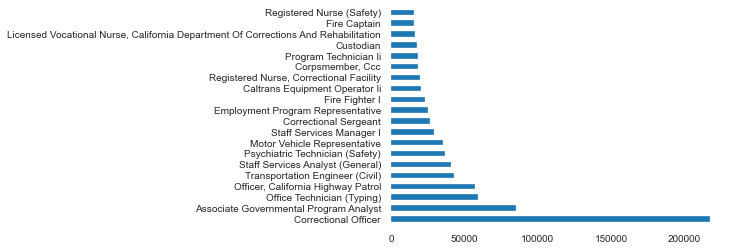

In [6]:
df['Job Title'].value_counts()[0:20].plot(kind='barh')

# Compute Genders

In [7]:
df['First Name'] = df['Employee Name'].str.split(n=2).str[0]

In [8]:
d = gender.Detector()
df['Gender'] = df['First Name'].apply(lambda name: d.get_gender(name.title()))


# Rate limited, so let's not use this for now
# Genderize().get(df['First Name'])

In [9]:
df[['First Name', 'Gender']][0:100]

,First Name,Gender
0,Mohammad,male
1,Gertrudis,female
2,Joseph,male
3,Thomas,male
4,Curtis,male
...,...,...
95,Michael,male
96,Theodore,male
97,Dennis,male
98,Wadsworth,unknown


### Gender Distribution

<AxesSubplot:>

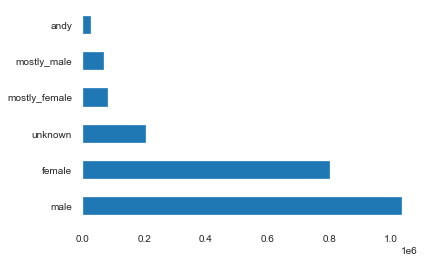

In [10]:
df['Gender'].value_counts()[0:100].plot(kind='barh')

In [11]:
median_salary_df = df.groupby(['Gender'])['Base Pay'].median()

In [12]:
median_salary_df

Gender
andy             60797.245
female           51399.610
male             63782.960
mostly_female    53748.000
mostly_male      59676.845
unknown          55787.495
Name: Base Pay, dtype: float64

### Check on Duplicates
Remove any employee name that appears in a year more than once.

@TODO Review whether this step is necessary or not

In [13]:
dupes_df = df.groupby(['Year', 'Employee Name'])['Base Pay'].count()

In [14]:
dupes_df[dupes_df > 1].sort_values(ascending=False)[0:50]

Year  Employee Name              
2011   Name Withheld                 652
2016  Name Withheld Name Withheld    572
2019   Name Withheld                 569
2017  Name Withheld Name Withheld    564
2018  Name Withheld Name Withheld    562
2015  Name Withheld Name Withheld    555
2012   Name Withheld                 547
2014  Name Withheld Name Withheld    526
2013  Name Withheld Name Withheld    495
2019  Amandeep Kaur                   12
2018  Mandeep Kaur                    11
      Amandeep Kaur                   11
2019  Mandeep Kaur                    11
2017  Mandeep Kaur                    10
2016  Jose L Hernandez                 9
2015  Jose L Hernandez                 9
2014  Daniel Garcia                    9
2012  Daniel Garcia                    9
2017  Amandeep Kaur                    8
2011  Daniel Garcia                    8
2016  David Rodriguez                  8
2017  Daniel Lopez                     8
2013  Patricia Garcia                  8
2019  Jose Ramirez     

### Look at distributions

In [15]:
from scipy import stats
import ipywidgets as widgets

In [16]:
popular_jobs_df = df.groupby(['Job Title'], as_index=False)['Employee Name'] \
    .count() \
    .rename(columns={"Employee Name": "Count"}) \
    .sort_values(["Count"], ascending=False)

In [17]:
popular_jobs_df

,Job Title,Count
1366,Correctional Officer,217781
536,Associate Governmental Program Analyst,84940
3346,Office Technician (Typing),58947
3352,"Officer, California Highway Patrol",57384
5152,Transportation Engineer (Civil),43003
...,...,...
470,"Associate Analyst, Health Professions Educatio...",1
1706,Deputy Secretary For Agriculture,1
1708,Deputy Secretary For Business Ovrsight And Age...,1
1709,Deputy Secretary For Climate And Energy,1


## Collapse down to one row per name

In [18]:
df['Year in Job'] = df.groupby(['Employee Name', 'Job Title'])['Year'].rank("dense", ascending=True)

grouped_df = df.groupby(['Gender', 'First Name', 'Employee Name', 'Year'], as_index=False).agg(
    total_base_pay = ('Base Pay', 'sum'), 
    job_title = ('Job Title', 'first'),
    other_titles = ('Job Title', lambda x: '|'.join(x[1:])),
    job_count = ('Base Pay', lambda x: len(x)),
    benefits = ('Benefits', 'sum'),
    other_pay = ('Other Pay', 'sum'),
    overtime_pay = ('Overtime Pay', 'sum'),
    total_pay = ('Total Pay', 'sum'),
    total_pay_and_benefits = ('Total Pay & Benefits', 'sum'),
    min_year_in_job = ('Year in Job', min),
    max_year_in_job = ('Year in Job', max)    
)


### Add a year number column (based on years in the database, by employee name)

In [19]:
grouped_df['Year Number'] = grouped_df.groupby(['Employee Name'])['Year'].rank("dense", ascending=True)

In [20]:
grouped_df['Year Number Descending'] = grouped_df.groupby(['Employee Name'])['Year'].rank("dense", ascending=False)

In [21]:
grouped_df = grouped_df.rename(columns={
    'total_base_pay': 'Base Pay',
    'job_title': 'Job Title',
    'other_titles': 'Other Job Titles',
    'statuses': 'Status',
    'job_count': 'Job Count In Year',
    'benefits': 'Benefits',
    'other_pay': 'Other Pay',
    'overtime_pay': 'Overtime Pay',
    'total_pay': 'Total Pay',
    'total_pay_and_benefits': 'Total Pay & Benefits',
    'min_year_in_job': 'Min Years In Job',
    'max_year_in_job': 'Max Years in Job'
})


In [22]:
grouped_df

,Gender,First Name,Employee Name,Year,Base Pay,Job Title,Other Job Titles,Job Count In Year,Benefits,Other Pay,Overtime Pay,Total Pay,Total Pay & Benefits,Min Years In Job,Max Years in Job,Year Number,Year Number Descending
0,andy,Adarsh,Adarsh Kaur,2011,203788.91,"Dentist, Correctional Facility",,1.0,0.00,0.00,811.20,204600.11,204600.11,1.0,1.0,1.0,9.0
1,andy,Adarsh,Adarsh Kaur,2012,218272.74,"Dentist, Correctional Facility",,1.0,0.00,4389.69,0.00,222662.43,222662.43,2.0,2.0,2.0,8.0
2,andy,Adarsh,Adarsh Kaur,2013,214853.98,"Dentist, Correctional Facility",,1.0,55451.36,2152.30,0.00,217006.28,272457.64,3.0,3.0,3.0,7.0
3,andy,Adarsh,Adarsh Kaur,2014,237181.13,"Dentist, Correctional Facility",,1.0,61947.00,2000.00,0.00,239181.13,301128.13,4.0,4.0,4.0,6.0
4,andy,Adarsh,Adarsh Kaur,2015,268451.75,"Supervising Dentist, Correctional Facility",,1.0,70851.63,1694.00,3205.61,273351.36,344202.99,1.0,1.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164852,unknown,Zuwena,Zuwena I Lee,2016,62696.72,Correctional Officer,,1.0,34559.45,3709.48,4580.55,70986.75,105546.20,3.0,3.0,3.0,4.0
2164853,unknown,Zuwena,Zuwena I Lee,2017,69140.95,Correctional Officer,,1.0,41022.44,3824.12,1298.11,74263.18,115285.62,4.0,4.0,4.0,3.0
2164854,unknown,Zuwena,Zuwena I Lee,2018,73553.72,Correctional Officer,,1.0,46349.22,4373.32,13981.94,91908.98,138258.20,5.0,5.0,5.0,2.0
2164855,unknown,Zuwena,Zuwena I Lee,2019,83517.32,Correctional Counselor I,,1.0,0.00,1616.45,2349.18,87482.95,87482.95,1.0,1.0,6.0,1.0


# Match it up with PublicPay data, where possible

In [23]:
pp_df = pd.read_csv('public_pay_rounded.csv.zip', compression='zip')

# Rename columns to match TransparentCalifornia
pp_df = pp_df.rename(columns={
    'RegularPay': 'Base Pay',
    'OvertimePay': 'Overtime Pay',
    'OtherPay': 'Other Pay',
    'TotalWages': 'Total Pay',
    'TotalRetirementAndHealthContribution': 'Benefits'
})

pp_df['Job Title'] = pp_df['Position'].str.replace(', *Range [A-Z0-9]$', '', regex=True)


/Users/bryanchan/.pyenv/versions/3.7.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
# These columns might form a unique join to fetch salary ranges
# Try a sequence of join columns for each row
join_columns = [
    ['Job Title', 'Year', 'Base Pay', 'Other Pay', 'Overtime Pay', 'Total Pay', 'Benefits'],
    ['Job Title', 'Year', 'Base Pay'],
    ['Job Title', 'Year', 'Benefits'],
    ['Job Title', 'Year']
]


# Note that this is often the case, but it's imperfect
check_df = grouped_df.groupby(join_columns[0], as_index=False).agg(
    count=('Employee Name', 'count'),
    first_name=('Employee Name', 'first')
)
print(check_df[(check_df['count'] > 1) & (check_df['Year'] == 2018)])


                            Job Title  Year  Base Pay  Other Pay  \
3392        Accountant I (Specialist)  2018   3106.62       0.00   
3593        Accountant I (Specialist)  2018  40859.48       0.00   
3616        Accountant I (Specialist)  2018  42727.04       0.00   
3617        Accountant I (Specialist)  2018  42749.84       0.00   
3649        Accountant I (Specialist)  2018  45236.60       0.00   
...                               ...   ...       ...        ...   
1977264                     Youth Aid  2018    396.00       0.00   
1977337                     Youth Aid  2018    938.08       0.00   
1977391                     Youth Aid  2018   1826.44       0.00   
1977395                     Youth Aid  2018   1887.60       0.00   
1980092  Youth Correctional Counselor  2018  16332.34     281.72   

         Overtime Pay  Total Pay  Benefits  count               first_name  
3392              0.0    3106.62   1543.23      2       Diana Sonemanivong  
3593              0.0   40859

In [25]:
pay_range_df = []
for cols in join_columns:
    if cols == ['Job Title', 'Year']:
        pp_df = pp_df[pp_df['MaxPositionSalary'] > 10000]
        
    result = pp_df.groupby(cols, as_index=False).agg(
            salary_range_min = ('MinPositionSalary', min),
            salary_range_max = ('MaxPositionSalary', max),
            first_position = ('Position', 'first'),
            last_position = ('Position', 'last'),
            salary_range_min_countd = ('MinPositionSalary', pd.Series.nunique),
            salary_range_max_countd = ('MaxPositionSalary', pd.Series.nunique)
        )
    result = result[result['salary_range_min_countd'] == 1]
    pay_range_df.append(result)

                                                 Job Title  Year  Base Pay  \
0                                                       02  2015  12887.82   
1                                                       02  2015  25645.20   
2                                                       02  2015  48605.10   
3                                                       02  2015  55605.70   
4                                                       02  2015  56095.80   
...                                                    ...   ...       ...   
2356801  Zero Emission Vehicle Infrastructure Project M...  2014  65752.21   
2356802  Zero Emission Vehicle Infrastructure Project M...  2016  21174.08   
2356803  Zero Emission Vehicle Infrastructure Project M...  2017  92862.24   
2356804  Zero Emission Vehicle Infrastructure Project M...  2018  95155.68   
2356805  Zero Emission Vehicle Policy Advisor To The Chair  2018  85492.64   

         Other Pay  Overtime Pay  Total Pay  Benefits  salary_r

                                               Job Title  Year  \
0                                                     02  2015   
1                                                     02  2016   
2                                                     02  2017   
3                                                     02  2018   
4                                       Account Clerk Ii  2009   
...                                                  ...   ...   
39092  Zero Emission Vehicle Infrastructure Project M...  2014   
39093  Zero Emission Vehicle Infrastructure Project M...  2016   
39094  Zero Emission Vehicle Infrastructure Project M...  2017   
39095  Zero Emission Vehicle Infrastructure Project M...  2018   
39096  Zero Emission Vehicle Policy Advisor To The Chair  2018   

       salary_range_min  salary_range_max  \
0               35668.8           65862.0   
1               36417.6           67244.4   
2               37292.4           68857.2   
3               44082.0    

In [26]:
# Try to successively join and make sure each result is in the same order
reset_grouped_df = grouped_df.reset_index()
output_df = None
for cols, pr_df in zip(join_columns, pay_range_df):
    result_df = reset_grouped_df.merge(pr_df, 
                             on = cols,
                             how = 'left',
                             indicator = True,
                             sort = False,
                             validate = 'many_to_one').sort_values('index')
    if output_df is None:
            output_df = result_df
    else:        
        mask = output_df['_merge'] != 'both'
        output_df[mask] = result_df[mask]
        
        success = len(output_df[output_df['_merge'] == 'both'])
        print(f'Successfully joined: { success } / {len(output_df)}')

Successfully joined: 1522461 / 2164857
Successfully joined: 1709145 / 2164857
Successfully joined: 1750635 / 2164857


In [83]:
# Try to join by salary range
srby_df = pd.read_csv('salary_range_by_year.csv')
srby_df['Job Title'] = srby_df['Position'].str.replace(', *Range [A-Z0-9]$', '', regex=True)
srby_df = srby_df.reset_index()

#Make the db in memory
conn = sqlite3.connect(':memory:')

#write the tables
remainder_df = output_df[output_df['_merge'] != 'both']
srby_df.to_sql('salary_range_by_year', conn, index=False)
remainder_df.to_sql('remainder', conn, index=False)
print(len(remainder_df))


/Users/bryanchan/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/core/generic.py:2612: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


414222


In [94]:
qry = '''
select r2.*, srby2.* FROM 
    (select r_index, min(srby_index) as srby_index, count(distinct(srby_index)) FROM
        (select r."index" r_index, r.'Base Pay', srby."index" as srby_index, srby.Position, srby.'MinPositionSalary', srby.'MinPositionSalary' from remainder r
        left join salary_range_by_year srby
            on r.'Job Title' = srby.'Job Title' 
            and r.'Year' = srby.'Year'
            and r.'Base Pay' > srby.'MinPositionSalary' 
            and r.'Base Pay' < srby.'MaxPositionSalary') t1
        GROUP BY 1 HAVING COUNT(DISTINCT(srby_index)) = 1) lookup
    JOIN remainder r2 on lookup.r_index = r2."index"
    JOIN salary_range_by_year srby2 ON lookup.srby_index = srby2."index"
'''
qry_df = pd.read_sql_query(qry, conn)
qry_df

,index,Gender,First Name,Employee Name,Year,Base Pay,Job Title,Other Job Titles,Job Count In Year,Benefits,...,_merge,index,Position,Year,MinPositionSalary,MaxPositionSalary,Count,Sample Employer Name,Distinct Employer Names,Job Title
0,43,andy,Ae,Ae Tern,2011,68965.31,Transportation Engineer (Civil),,1.0,0.0,...,left_only,46004,"Transportation Engineer (Civil), Range B",2011,63312.0,76908.0,45,"Transportation, Department of",1,Transportation Engineer (Civil)
1,44,andy,Ae,Ae Tern,2012,79246.31,Transportation Engineer (Civil),,1.0,0.0,...,left_only,46015,"Transportation Engineer (Civil), Range C",2012,73236.0,88956.0,2098,"Fish and Wildlife, Department of",2,Transportation Engineer (Civil)
2,125,andy,Alva,Alva T Valdez,2012,48482.35,Employment Program Representative,,1.0,0.0,...,left_only,16740,"Employment Program Representative, Range C",2012,42036.0,51072.0,3001,Employment Development Department,2,Employment Program Representative
3,225,andy,An,An Ho,2011,26710.98,Office Assistant (General),,1.0,0.0,...,left_only,28336,"Office Assistant (General), Range A",2011,24888.0,30228.0,64,"Aging, Department of",22,Office Assistant (General)
4,258,andy,An,An P Do,2011,82109.36,Transportation Engineer (Civil),,1.0,0.0,...,left_only,46014,"Transportation Engineer (Civil), Range C",2011,73236.0,88956.0,2266,"Fish and Wildlife, Department of",2,Transportation Engineer (Civil)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49063,2164383,unknown,Zjay,Zjay C Lee,2012,63595.92,Correctional Officer,,1.0,0.0,...,left_only,11488,"Correctional Officer, Range K",2012,60660.0,73728.0,23068,"Corrections & Rehabilitation, Department of",1,Correctional Officer
49064,2164398,unknown,Zobeida,Zobeida O Morales,2011,50096.70,Employment Program Representative,,1.0,0.0,...,left_only,16739,"Employment Program Representative, Range C",2011,42036.0,51072.0,2873,Employment Development Department,2,Employment Program Representative
49065,2164399,unknown,Zobeida,Zobeida O Morales,2012,45140.92,Employment Program Representative,,1.0,0.0,...,left_only,16740,"Employment Program Representative, Range C",2012,42036.0,51072.0,3001,Employment Development Department,2,Employment Program Representative
49066,2164502,unknown,Zongnan,Zongnan S Sun,2012,89473.68,"Transportation Engineer, (Electrical)",,1.0,0.0,...,left_only,46063,"Transportation Engineer, (Electrical), Range D",2012,82764.0,100548.0,248,"Transportation, Department of",1,"Transportation Engineer, (Electrical)"


TypeError: 'Series' objects are mutable, thus they cannot be hashed

<AxesSubplot:>

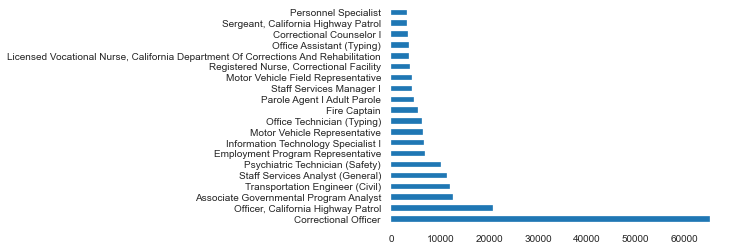

In [31]:
remainder_df['Job Title'].value_counts()[0:20].plot(kind='barh')

In [32]:
remainder_df[remainder_df['Job Title'] == 'Correctional Officer']

,index,Gender,First Name,Employee Name,Year,Base Pay,Job Title,Other Job Titles,Job Count In Year,Benefits,...,Max Years in Job,Year Number,Year Number Descending,salary_range_min,salary_range_max,first_position,last_position,salary_range_min_countd,salary_range_max_countd,_merge
28,28,andy,Addison,Addison Tringale,2019,50174.60,Correctional Officer,,1.0,0.0,...,6.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
40,40,andy,Ae,Ae L Vue,2019,19834.73,Correctional Officer,,1.0,0.0,...,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
370,370,andy,Ashton,Ashton O'Boyle-Womeldorf,2019,79292.00,Correctional Officer,,1.0,0.0,...,6.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
388,388,andy,Ashton,Ashton Simpo,2019,79126.00,Correctional Officer,,1.0,0.0,...,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
465,465,andy,Aubrey,Aubrey D Ballard,2019,56687.00,Correctional Officer,,1.0,0.0,...,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164514,2164514,unknown,Zontrel,Zontrel Rayford,2011,71245.96,Correctional Officer,,1.0,0.0,...,1.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2164515,2164515,unknown,Zontrel,Zontrel Rayford,2012,74419.68,Correctional Officer,,1.0,0.0,...,2.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2164522,2164522,unknown,Zontrel,Zontrel Rayford,2019,96603.85,Correctional Officer,,1.0,0.0,...,9.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2164728,2164728,unknown,Zulema,Zulema E Medina,2011,67941.37,Correctional Officer,,1.0,0.0,...,1.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [95]:
print(len(grouped_df))
print(len(output_df))
print('Not joined:')
print(output_df[output_df['_merge'] != 'both'])

2164857
2164857
Not joined:
           index   Gender First Name           Employee Name  Year   Base Pay  \
0              0     andy     Adarsh             Adarsh Kaur  2011  203788.91   
8              8     andy     Adarsh             Adarsh Kaur  2019  335871.00   
9              9     andy    Addison  Addison  R Adsit Metts  2019    2430.00   
18            18     andy    Addison        Addison G Embrey  2019   75812.00   
22            22     andy    Addison        Addison G Fisher  2019   64520.00   
...          ...      ...        ...                     ...   ...        ...   
2164833  2164833  unknown     Zurick          Zurick Sellers  2019    7197.27   
2164838  2164838  unknown     Zuriel          Zuriel J Smith  2019   71000.00   
2164848  2164848  unknown  Zurisadai       Zurisadai Morales  2019   38041.67   
2164849  2164849  unknown       Zury          Zury Velazquez  2019   42085.00   
2164855  2164855  unknown     Zuwena            Zuwena I Lee  2019   83517.32   


In [35]:
output_df.to_csv('salary_data.csv', index=True)

## Upload to data.world

In [36]:
client = dw.api_client()
client.upload_files('fryanpan13/california-public-salary-data',files='salary_data.csv')


### Select a Job

In [37]:
job_select = widgets.Select(
    options=popular_jobs_df.sort_values(["Count"], ascending=False)["Job Title"][0:100],
)
display(job_select)

Select(options=('Correctional Officer', 'Associate Governmental Program Analyst', 'Office Technician (Typing)'…

### Plot Gender Distributions

Correctional Officer


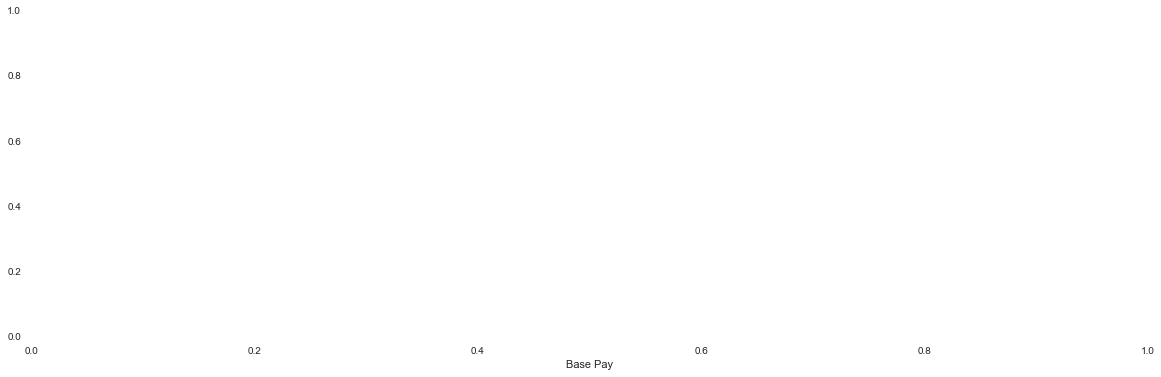

In [38]:
def plot(job_title, gender, ax, color):
    gender_df = grouped_df[(grouped_df['Job Title'] == f'"{job_title}"') & 
                           (grouped_df['Gender'] == gender) & 
                           (grouped_df['Year Number'] == 2)]
    sns.distplot(gender_df['Base Pay'], ax=ax, hist=False, kde=True, kde_kws={'cumulative': True}, color=color)
    
def update_plot(event):
    print(job_select.value)
    fig, ax = plt.subplots(figsize=(20,6))
    
    plot(job_select.value, 'female', ax, 'orange')
    plot(job_select.value, 'male', ax, 'green')
    
update_plot(5)